
https://www.dane.gov.co/index.php/estadisticas-por-tema/mercado-laboral/empleo-y-desempleo

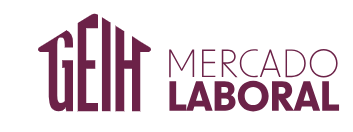

# Procesamiento y Transformación

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt

# Cargamos Excel
file_path = '/content/anex-GEIH-dic2024.xlsx'
sheet_name = 'Total nacional'

data = pd.read_excel(file_path, sheet_name=sheet_name)

# Validamos que columnas no estén combinadas
data.columns = data.columns.to_flat_index()
data.columns = [col if isinstance(col, str) else str(col) for col in data.columns]

# Extraemos fila con palabra inicial "Concepto"

concepto_row = data[data.apply(lambda row: row.astype(str).str.contains("Concepto", case=False, na=False).any(), axis=1)]
concepto_row_unique = concepto_row.iloc[[0]]  # Aseguramos que solo primera ocurrencia es extraída

# Extraemos fila inmediatamente siguiente

if not concepto_row_unique.empty:
    concepto_index = concepto_row_unique.index[0]
    next_row = data.iloc[[concepto_index + 1]]
else:
    next_row = pd.DataFrame()

# Obtenemos fila de "Tasa de Ocupación (TO)" después de "Concepto"
if not concepto_row_unique.empty:
    to_row = data.iloc[concepto_index + 1:]  # Buscamos solo después "Concepto"
    to_row = to_row[to_row.iloc[:, 0].astype(str).str.contains("Tasa de Ocupación \\(TO\\)", case=False, na=False)].iloc[[0]]
else:
    to_row = pd.DataFrame()

# Obtenemos fila de "Tasa de Subocupación (TS)" después de "Concepto"
if not concepto_row_unique.empty:
    ts_row = data.iloc[concepto_index + 1:]  # Buscamos solo después "Concepto"
    ts_row = ts_row[ts_row.iloc[:, 0].astype(str).str.contains("Tasa de Subocupación \\(TS\\)", case=False, na=False)].iloc[[0]]
else:
    ts_row = pd.DataFrame()

# Obtenemos fila de "Tasa de Desocupación (TD)" después de "Concepto"

if not concepto_row_unique.empty:
    td_row = data.iloc[concepto_index + 1:]  # Buscamos solo después "Concepto"
    td_row = td_row[td_row.iloc[:, 0].astype(str).str.contains("Tasa de Desocupación \\(TD\\)", case=False, na=False)].iloc[[0]]
else:
    td_row = pd.DataFrame()

# Combinamos resultados en un solo DataFrame

final_extracted_rows = pd.concat([concepto_row_unique, next_row, td_row, to_row, ts_row], ignore_index=True)

# Nombramos filas 0 como 'Año' y 1 como 'Mes'

final_extracted_rows.iloc[0, 0] = 'Año'
final_extracted_rows.iloc[1, 0] = 'Mes'


# Inputamos fila de año

final_extracted_rows.iloc[0, 1:] = final_extracted_rows.iloc[0, 1:].ffill().astype(int)

# Reducimos a dos decimales

if not final_extracted_rows[final_extracted_rows.iloc[:, 0].str.contains("Tasa de Desocupación \\(TD\\)", case=False, na=False)].empty:
    td_row_index = final_extracted_rows[final_extracted_rows.iloc[:, 0].str.contains("Tasa de Desocupación \\(TD\\)", case=False, na=False)].index[0]
    final_extracted_rows.iloc[td_row_index, 1:] = final_extracted_rows.iloc[td_row_index, 1:].astype(float).round(2)

if not final_extracted_rows[final_extracted_rows.iloc[:, 0].str.contains("Tasa de Ocupación \\(TO\\)", case=False, na=False)].empty:
    to_row_index = final_extracted_rows[final_extracted_rows.iloc[:, 0].str.contains("Tasa de Ocupación \\(TO\\)", case=False, na=False)].index[0]
    final_extracted_rows.iloc[to_row_index, 1:] = final_extracted_rows.iloc[to_row_index, 1:].astype(float).round(2)

if not final_extracted_rows[final_extracted_rows.iloc[:, 0].str.contains("Tasa de Subocupación \\(TS\\)", case=False, na=False)].empty:
    ts_row_index = final_extracted_rows[final_extracted_rows.iloc[:, 0].str.contains("Tasa de Subocupación \\(TS\\)", case=False, na=False)].index[0]
    final_extracted_rows.iloc[ts_row_index, 1:] = final_extracted_rows.iloc[ts_row_index, 1:].astype(float).round(2)


# Incorporamos mapeo de meses

mes_mapping = {
    "Ene": 1, "Feb": 2, "Mar": 3, "Abr": 4, "May": 5,
    "Jun": 6, "Jul": 7, "Ago": 8, "Sep": 9, "Oct": 10,
    "Nov": 11, "Dic": 12
}

if not final_extracted_rows[final_extracted_rows.iloc[:, 0] == "Mes"].empty:
    mes_row_index = final_extracted_rows[final_extracted_rows.iloc[:, 0] == "Mes"].index[0]
    final_extracted_rows.iloc[mes_row_index, 1:] = final_extracted_rows.iloc[mes_row_index, 1:].map(mes_mapping)

# Creamos Serie de Tiempo

time_series_df = pd.DataFrame({
    'Year': final_extracted_rows.iloc[0, 1:].values,
    'Month': final_extracted_rows.iloc[1, 1:].values,
    'Tasa de Desocupación (TD)': final_extracted_rows.iloc[2, 1:].values,
    'Tasa de Ocupación (TO)': final_extracted_rows.iloc[3, 1:].values,
    'Tasa de Subocupación (TS)': final_extracted_rows.iloc[4, 1:].values
}).dropna()

# Validamos formato de datos

time_series_df['Year'] = time_series_df['Year'].astype(int)
time_series_df['Month'] = time_series_df['Month'].astype(int)
time_series_df['Tasa de Desocupación (TD)'] = time_series_df['Tasa de Desocupación (TD)'].astype(float)

# Creamos columna de tiempo para gráfico

time_series_df['Date'] = pd.to_datetime(time_series_df[['Year', 'Month']].assign(Day=1))

# Identificamos periodo presidencial

subset_df = time_series_df[(time_series_df['Date'] >= '2022-08-01') & (time_series_df['Date'] <= '2024-12-31')]

# Validamos resultado parcial

time_series_df

<ipython-input-1-e5df059eea9b>:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_extracted_rows.iloc[0, 1:] = final_extracted_rows.iloc[0, 1:].ffill().astype(int)


,Year,Month,Tasa de Desocupación (TD),Tasa de Ocupación (TO),Tasa de Subocupación (TS),Date
0,2001,1,16.62,57.58,11.83,2001-01-01
1,2001,2,17.43,56.93,11.68,2001-02-01
2,2001,3,15.81,57.57,11.97,2001-03-01
3,2001,4,14.52,55.76,10.47,2001-04-01
4,2001,5,14.04,56.23,10.63,2001-05-01
...,...,...,...,...,...,...
283,2024,8,9.66,58.27,7.38,2024-08-01
284,2024,9,9.13,57.69,7.89,2024-09-01
285,2024,10,9.13,58.07,8.14,2024-10-01
286,2024,11,8.17,58.53,7.48,2024-11-01


# Tasa de Desocupación 2020-2024

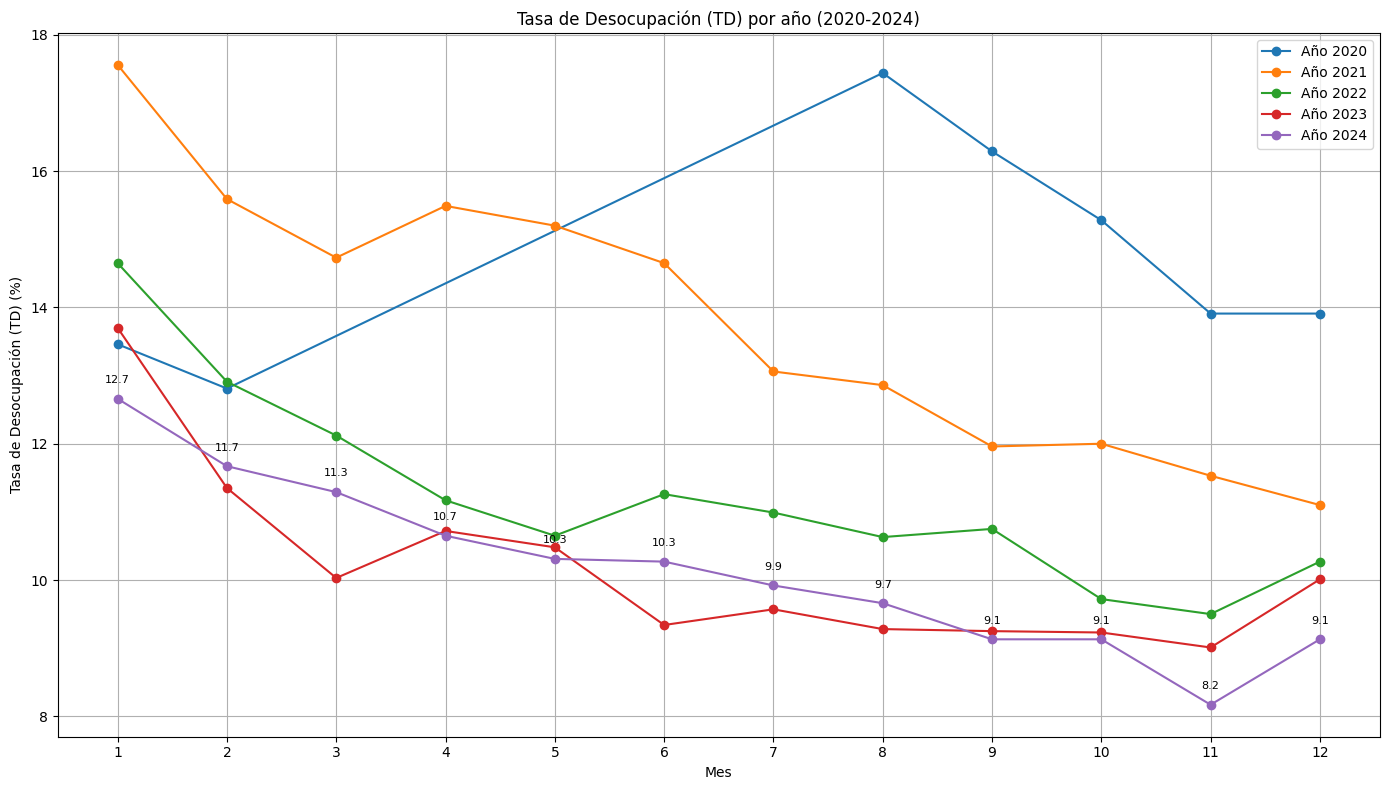

In [ ]:
# @title
filtered_years_df = time_series_df[(time_series_df['Year'] >= 2020) & (time_series_df['Year'] <= 2024)]

plt.figure(figsize=(14, 8))
for year, group in filtered_years_df.groupby('Year'):
    plt.plot(group['Month'], group['Tasa de Desocupación (TD)'],
             marker='o', linestyle='-', label=f'Año {year}')

    # Añadimos etiquetas solo para el año 2024
    if year == 2024:
        for x, y in zip(group['Month'], group['Tasa de Desocupación (TD)']):
            plt.text(x, y + 0.2, f'{y:.1f}', fontsize=8, ha='center', va='bottom')

plt.title('Tasa de Desocupación (TD) por año (2020-2024)')
plt.xlabel('Mes')
plt.ylabel('Tasa de Desocupación (TD) (%)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Tasa de Desocupación 2000-2024

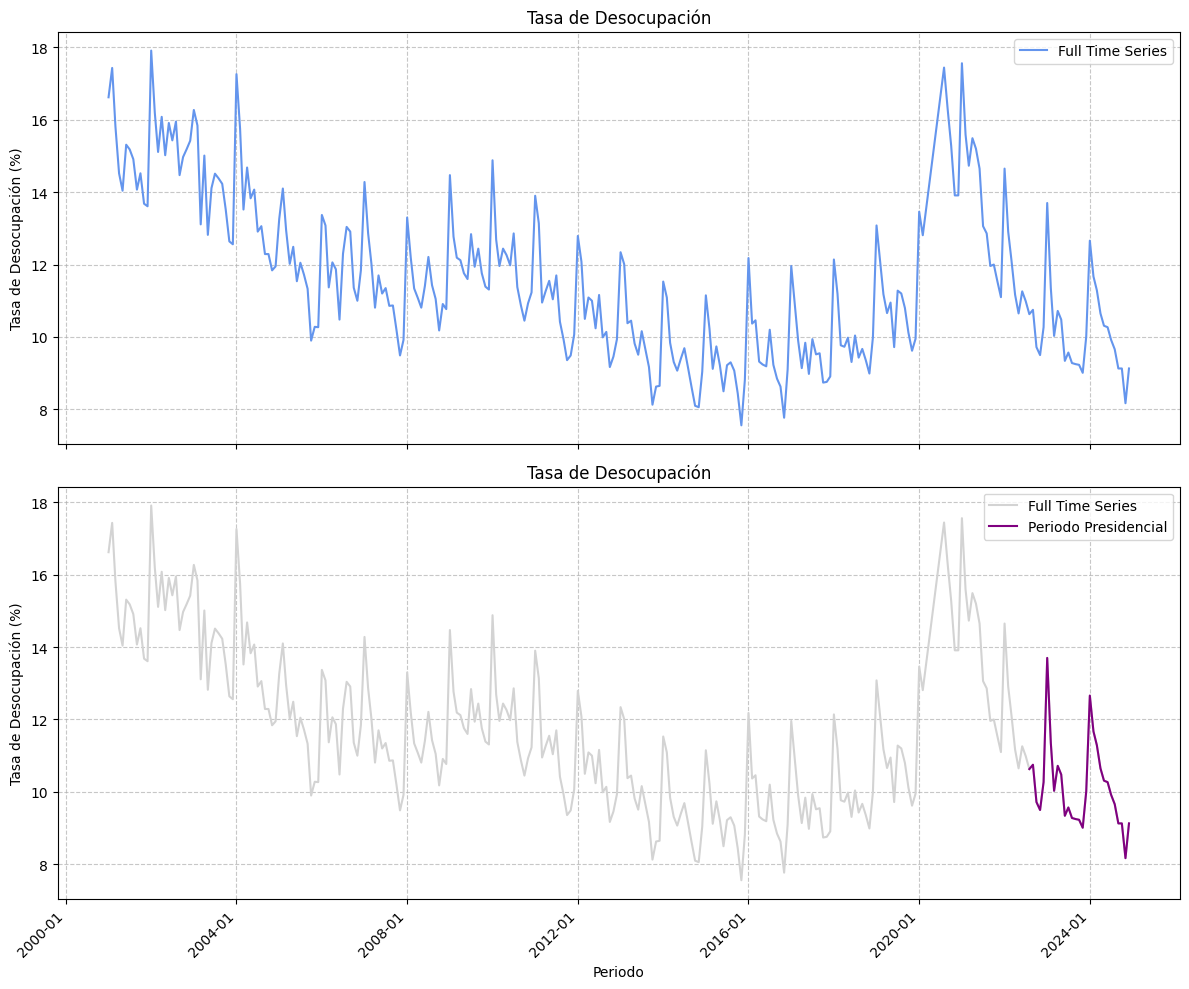

In [ ]:
# @title
# Creamos gráfico de serie total

import matplotlib.dates as mdates

# Creamos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Primer subplot
ax1.plot(time_series_df['Date'], time_series_df['Tasa de Desocupación (TD)'],
         color='cornflowerblue', label='Full Time Series')
ax1.set_title('Tasa de Desocupación')
ax1.set_ylabel('Tasa de Desocupación (%)')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Segundo subplot
ax2.plot(time_series_df['Date'], time_series_df['Tasa de Desocupación (TD)'],
         color='lightgray', label='Full Time Series')
ax2.plot(subset_df['Date'], subset_df['Tasa de Desocupación (TD)'],
         color='purple', label='Periodo Presidencial')
ax2.set_title('Tasa de Desocupación')
ax2.set_xlabel('Periodo')
ax2.set_ylabel('Tasa de Desocupación (%)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Formato
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#Tasa Desocupación Último Mes

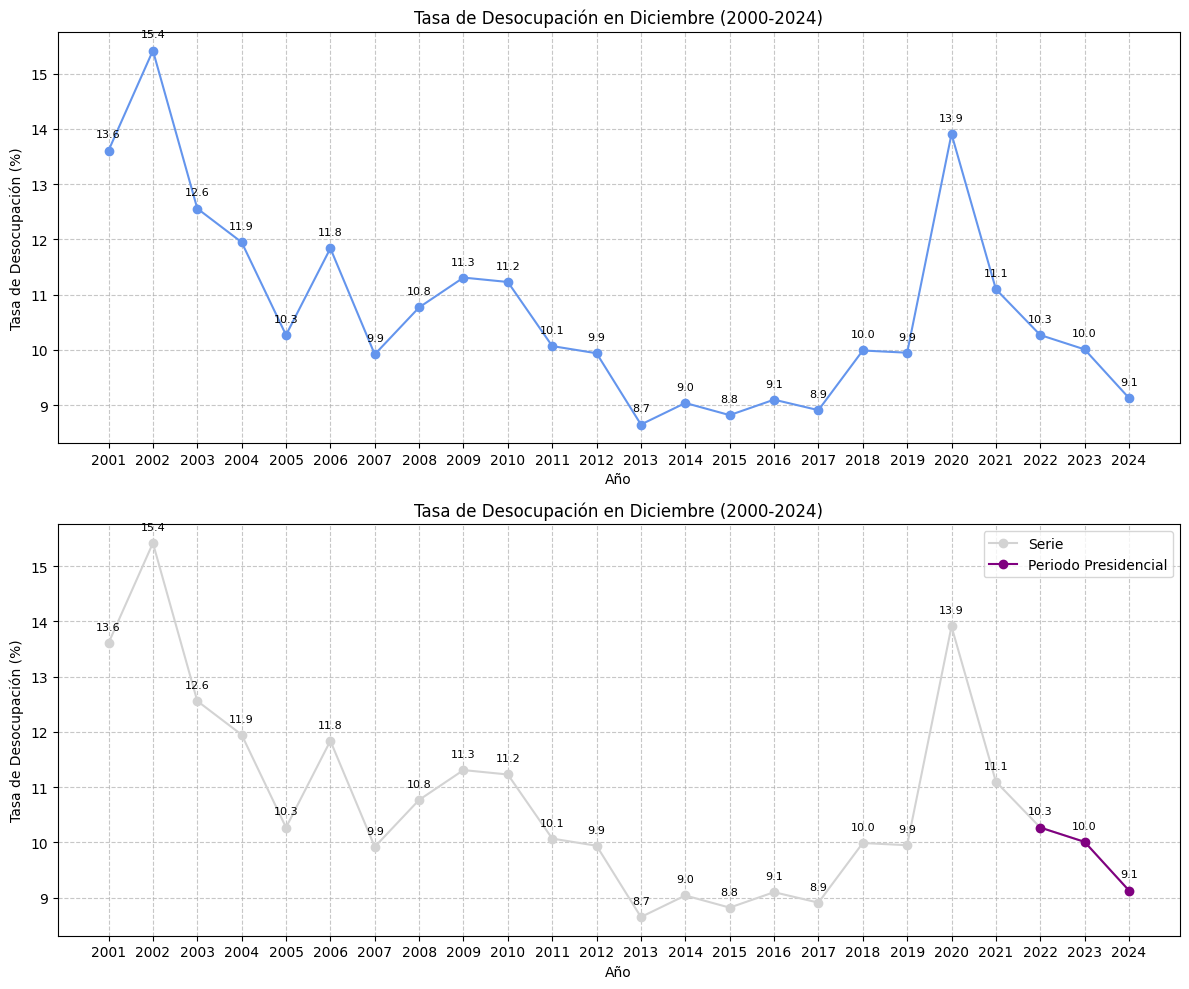

In [ ]:
# @title
import matplotlib.pyplot as plt

# Diccionario de nombres de meses en español
meses_espanol = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio",
    7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

# Identificamos último mes de la serie
last_year = time_series_df['Year'].max()
last_month = time_series_df[time_series_df['Year'] == last_year]['Month'].max()
nombre_mes = meses_espanol[last_month]

# Filtramos desde 2000 para último mes
last_months_df = time_series_df[
    (time_series_df['Month'] == last_month) &
    (time_series_df['Year'].between(2000, last_year))
]

# Graficamos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Primer Subplot
ax1.plot(last_months_df['Year'], last_months_df['Tasa de Desocupación (TD)'],
         marker='o', linestyle='-', color='cornflowerblue')
ax1.set_title(f'Tasa de Desocupación en {nombre_mes} (2000-{last_year})')
ax1.set_xlabel('Año')  # Etiqueta del eje X
ax1.set_ylabel('Tasa de Desocupación (%)')  # Etiqueta del eje Y
ax1.set_xticks(last_months_df['Year'])
ax1.grid(True, linestyle='--', alpha=0.7)

# Añadimos etiquetas a cada punto en el primer subplot
for x, y in zip(last_months_df['Year'], last_months_df['Tasa de Desocupación (TD)']):
    ax1.text(x, y+ 0.2, f'{y:.1f}', fontsize=8, ha='center', va='bottom')

# Segundo Subplot
ax2.plot(last_months_df['Year'], last_months_df['Tasa de Desocupación (TD)'],
         marker='o', linestyle='-', color='lightgray', label='Serie')

# Resaltamos periodo presidencial
subset_last_months = last_months_df[
    (last_months_df['Date'] >= '2022-08-01') &
    (last_months_df['Date'] <= '2024-12-31')
]
ax2.plot(subset_last_months['Year'], subset_last_months['Tasa de Desocupación (TD)'],
         marker='o', linestyle='-', color='purple', label='Periodo Presidencial')

ax2.set_title(f'Tasa de Desocupación en {nombre_mes} (2000-{last_year})')
ax2.set_xlabel('Año')  # Etiqueta del eje X
ax2.set_ylabel('Tasa de Desocupación (%)')  # Etiqueta del eje Y
ax2.set_xticks(last_months_df['Year'])
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Añadimos etiquetas a cada punto en el segundo subplot
for x, y in zip(last_months_df['Year'], last_months_df['Tasa de Desocupación (TD)']):
    ax2.text(x, y+0.2, f'{y:.1f}', fontsize=8, ha='center', va='bottom')

# Ajustamos el diseño
plt.tight_layout()

# Mostramos la gráfica
plt.show()


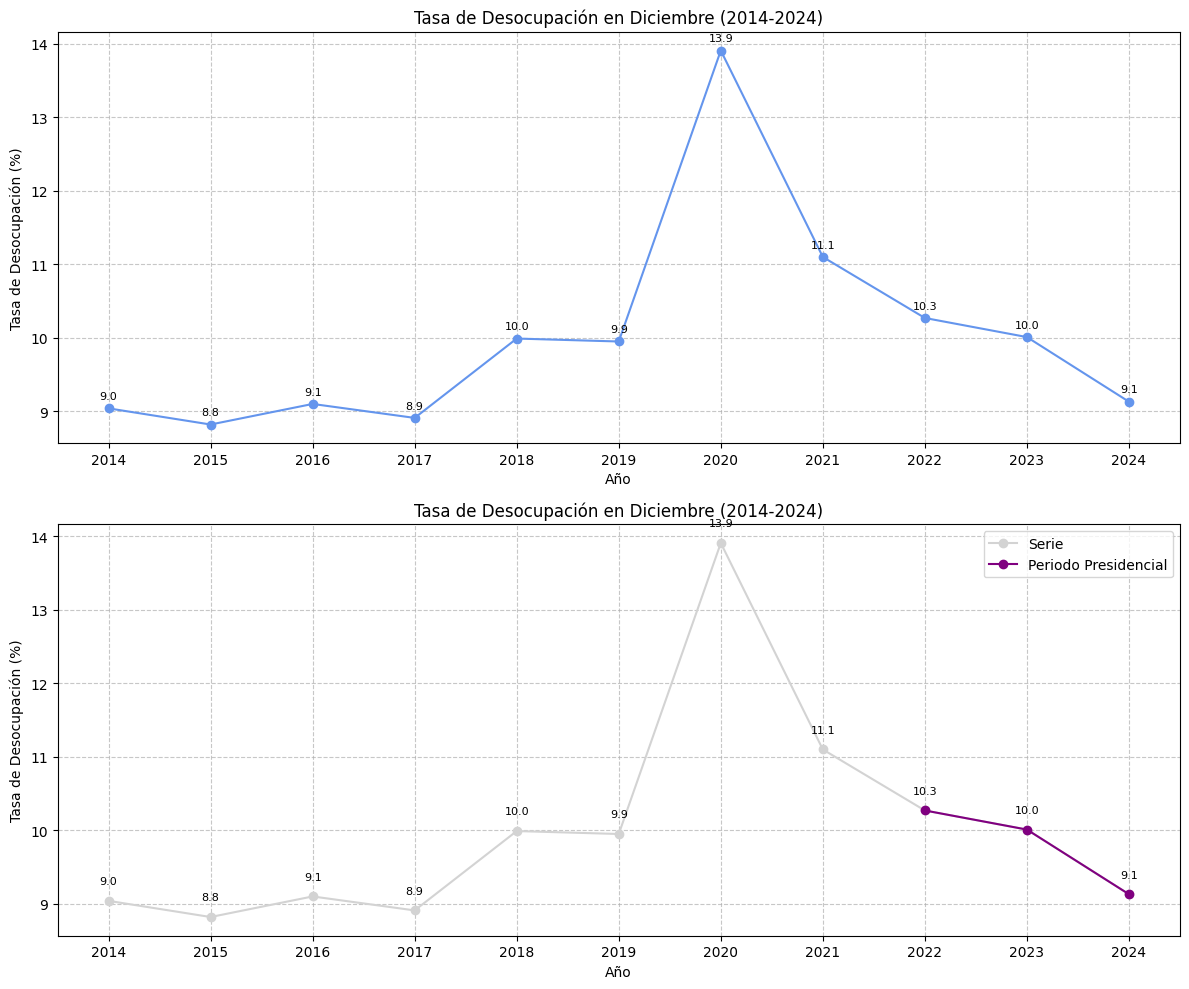

In [ ]:
# @title
import matplotlib.pyplot as plt

# Diccionario de nombres de meses en español
meses_espanol = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio",
    7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

nombre_mes = meses_espanol[last_month]

# Filtramos desde 2014 para último mes
last_months_df_1 = time_series_df[
    (time_series_df['Month'] == last_month) &
    (time_series_df['Year'].between(2014, last_year))
]

# Graficamos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Primer Subplot
ax1.plot(last_months_df_1['Year'], last_months_df_1['Tasa de Desocupación (TD)'],
         marker='o', linestyle='-', color='cornflowerblue')
ax1.set_title(f'Tasa de Desocupación en {nombre_mes} (2014-{last_year})')
ax1.set_xlabel('Año')
ax1.set_ylabel('Tasa de Desocupación (%)')
ax1.set_xticks(last_months_df_1['Year'])
ax1.grid(True, linestyle='--', alpha=0.7)

# Añadimos etiquetas a cada punto en el primer subplot

for x, y in zip(last_months_df_1['Year'], last_months_df_1['Tasa de Desocupación (TD)']):
    ax1.text(x, y + 0.1, f'{y:.1f}', fontsize=8, ha='center', va='bottom')  # Etiqueta arriba del punto

# Segundo Subplot

ax2.plot(last_months_df_1['Year'], last_months_df_1['Tasa de Desocupación (TD)'],
         marker='o', linestyle='-', color='lightgray', label='Serie')

# Resaltamos periodo presidencial
subset_last_months_1 = last_months_df_1[
    (last_months_df_1['Date'] >= '2022-08-01') &
    (last_months_df_1['Date'] <= '2024-12-31')
]
ax2.plot(subset_last_months_1['Year'], subset_last_months_1['Tasa de Desocupación (TD)'],
         marker='o', linestyle='-', color='purple', label='Periodo Presidencial')

ax2.set_title(f'Tasa de Desocupación en {nombre_mes} (2014-{last_year})')
ax2.set_xlabel('Año')
ax2.set_ylabel('Tasa de Desocupación (%)')
ax2.set_xticks(last_months_df_1['Year'])
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Añadimos etiquetas a cada punto en el segundo subplot
for x, y in zip(last_months_df_1['Year'], last_months_df_1['Tasa de Desocupación (TD)']):
    ax2.text(x, y + 0.2, f'{y:.1f}', fontsize=8, ha='center', va='bottom')  # Etiqueta arriba del punto

plt.tight_layout()
plt.show()


# TD, TO Último Mes 2014-2024

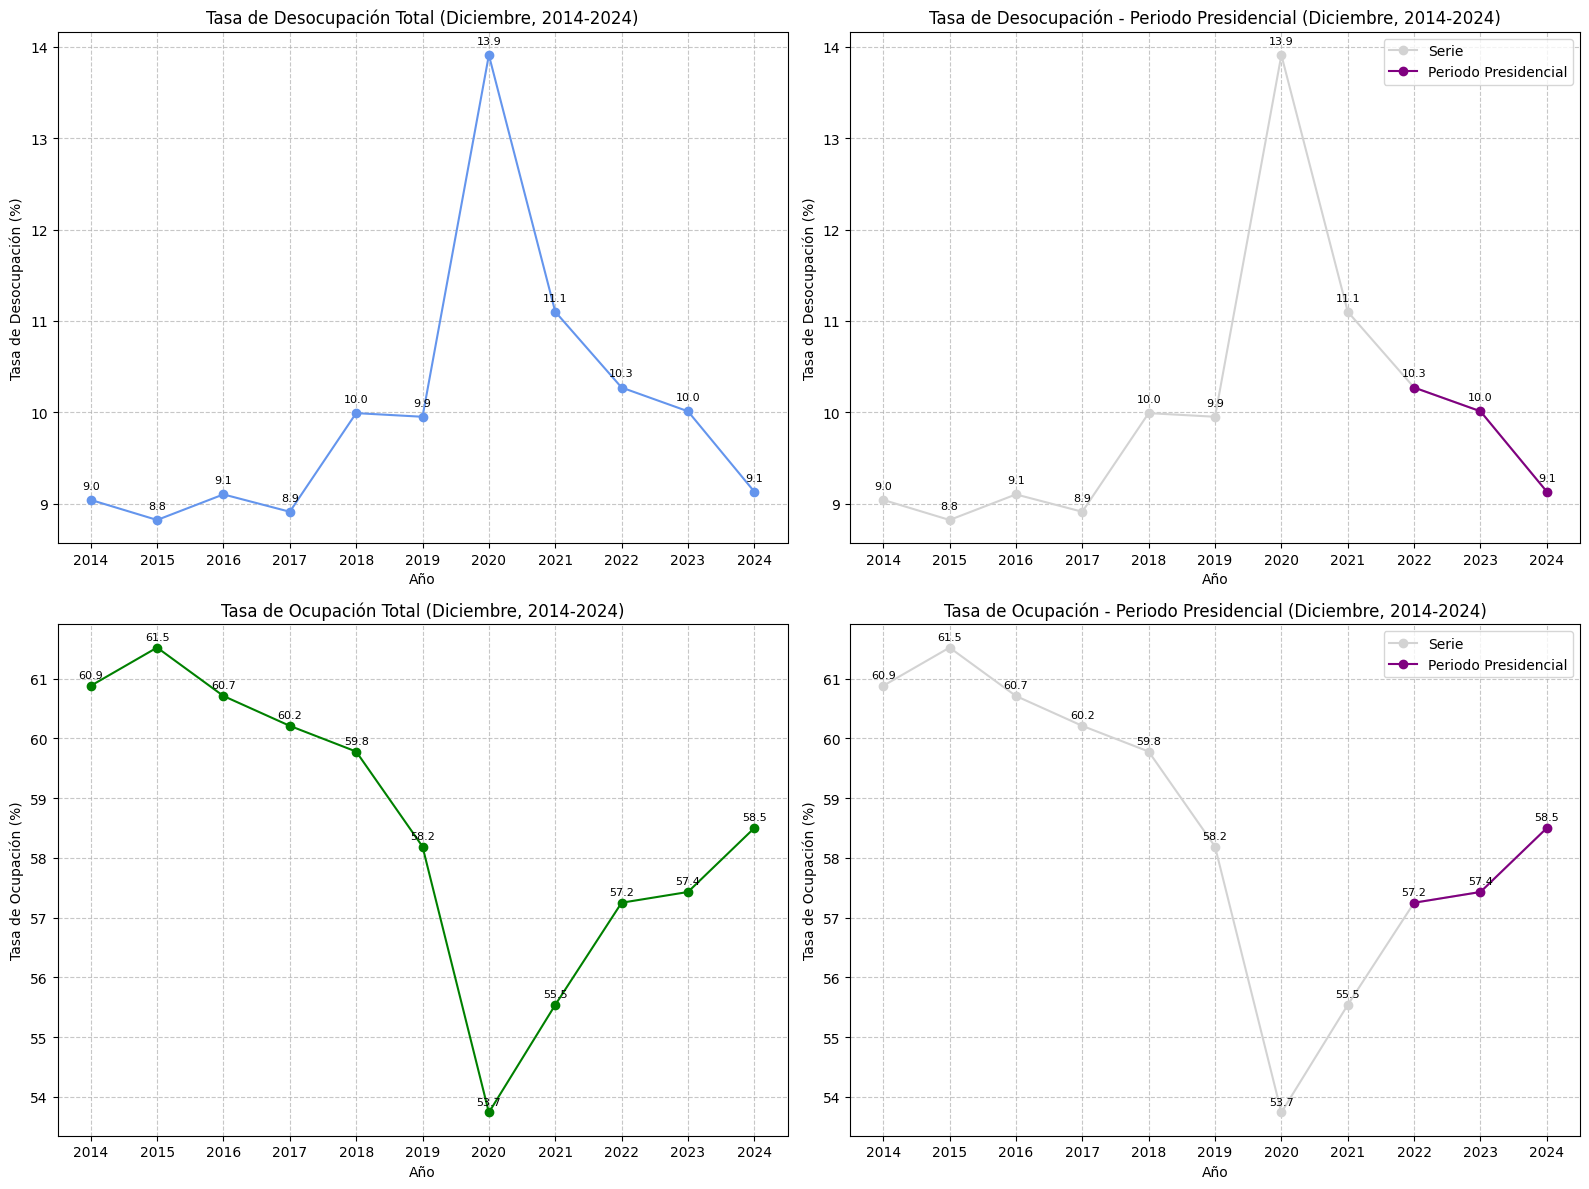

In [ ]:
# @title
import matplotlib.pyplot as plt

# Diccionario de nombres de meses en español
meses_espanol = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio",
    7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

nombre_mes = meses_espanol[last_month]

# Filtramos desde 2014 para último mes
last_months_df_1 = time_series_df[
    (time_series_df['Month'] == last_month) &
    (time_series_df['Year'].between(2014, last_year))
]

# Graficamos (Reducimos a 2x2 para eliminar los gráficos de TS)
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# TD Plots
axs[0, 0].plot(last_months_df_1['Year'], last_months_df_1['Tasa de Desocupación (TD)'],
               marker='o', linestyle='-', color='cornflowerblue')
axs[0, 0].set_title(f'Tasa de Desocupación Total ({nombre_mes}, 2014-{last_year})')
axs[0, 0].set_xlabel('Año')
axs[0, 0].set_ylabel('Tasa de Desocupación (%)')
axs[0, 0].set_xticks(last_months_df_1['Year'])
axs[0, 0].grid(True, linestyle='--', alpha=0.7)

for x, y in zip(last_months_df_1['Year'], last_months_df_1['Tasa de Desocupación (TD)']):
    axs[0, 0].text(x, y + 0.1, f'{y:.1f}', fontsize=8, ha='center', va='bottom')

axs[0, 1].plot(last_months_df_1['Year'], last_months_df_1['Tasa de Desocupación (TD)'],
               marker='o', linestyle='-', color='lightgray', label='Serie')
subset_last_months_1 = last_months_df_1[
    (last_months_df_1['Date'] >= '2022-08-01') &
    (last_months_df_1['Date'] <= '2024-12-31')
]
axs[0, 1].plot(subset_last_months_1['Year'], subset_last_months_1['Tasa de Desocupación (TD)'],
               marker='o', linestyle='-', color='purple', label='Periodo Presidencial')
axs[0, 1].set_title(f'Tasa de Desocupación - Periodo Presidencial ({nombre_mes}, 2014-{last_year})')
axs[0, 1].set_xlabel('Año')
axs[0, 1].set_ylabel('Tasa de Desocupación (%)')
axs[0, 1].set_xticks(last_months_df_1['Year'])
axs[0, 1].grid(True, linestyle='--', alpha=0.7)
axs[0, 1].legend()

for x, y in zip(last_months_df_1['Year'], last_months_df_1['Tasa de Desocupación (TD)']):
    axs[0, 1].text(x, y + 0.1, f'{y:.1f}', fontsize=8, ha='center', va='bottom')

# TO Plots
axs[1, 0].plot(last_months_df_1['Year'], last_months_df_1['Tasa de Ocupación (TO)'],
               marker='o', linestyle='-', color='green')
axs[1, 0].set_title(f'Tasa de Ocupación Total ({nombre_mes}, 2014-{last_year})')
axs[1, 0].set_xlabel('Año')
axs[1, 0].set_ylabel('Tasa de Ocupación (%)')
axs[1, 0].set_xticks(last_months_df_1['Year'])
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

for x, y in zip(last_months_df_1['Year'], last_months_df_1['Tasa de Ocupación (TO)']):
    axs[1, 0].text(x, y + 0.1, f'{y:.1f}', fontsize=8, ha='center', va='bottom')

axs[1, 1].plot(last_months_df_1['Year'], last_months_df_1['Tasa de Ocupación (TO)'],
               marker='o', linestyle='-', color='lightgray', label='Serie')
axs[1, 1].plot(subset_last_months_1['Year'], subset_last_months_1['Tasa de Ocupación (TO)'],
               marker='o', linestyle='-', color='purple', label='Periodo Presidencial')
axs[1, 1].set_title(f'Tasa de Ocupación - Periodo Presidencial ({nombre_mes}, 2014-{last_year})')
axs[1, 1].set_xlabel('Año')
axs[1, 1].set_ylabel('Tasa de Ocupación (%)')
axs[1, 1].set_xticks(last_months_df_1['Year'])
axs[1, 1].grid(True, linestyle='--', alpha=0.7)
axs[1, 1].legend()

for x, y in zip(last_months_df_1['Year'], last_months_df_1['Tasa de Ocupación (TO)']):
    axs[1, 1].text(x, y + 0.1, f'{y:.1f}', fontsize=8, ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Ocupación por Rama

In [ ]:
# @title
sheet_name = 'Ocupados TN_T13_rama'

data = pd.read_excel(file_path, sheet_name=sheet_name)

# Validamos index

data.columns = data.columns.to_flat_index()
data.columns = [col if isinstance(col, str) else str(col) for col in data.columns]

# Extraemos fila con "Concepto"

concepto_row = data[data.apply(lambda row: row.astype(str).str.contains("Concepto", case=False, na=False).any(), axis=1)]
concepto_row_unique = concepto_row.iloc[[0]] if not concepto_row.empty else pd.DataFrame()

# Extraemos fila subsiguiente

if not concepto_row_unique.empty:
    concepto_index = concepto_row_unique.index[0]
    next_row = data.iloc[[concepto_index + 1]]
else:
    next_row = pd.DataFrame()

# Extraemos filas relacionadas con "Población ocupada Total nacional"

poblacion_row = data[data.apply(lambda row: row.astype(str).str.contains("Población ocupada Total nacional", case=False, na=False).any(), axis=1)]

if not poblacion_row.empty:
    poblacion_index = poblacion_row.index[0]
    # Extraemos siguientes 15 filas
    poblacion_next_15_rows = data.iloc[poblacion_index : poblacion_index + 16].copy()

    # Asignamos encabezados

    poblacion_next_15_rows.columns = poblacion_next_15_rows.iloc[0]
    poblacion_next_15_rows = poblacion_next_15_rows.iloc[1:].reset_index(drop=True)
else:
    poblacion_next_15_rows = pd.DataFrame()

# Aseguramos nombre únicos de columnas para cada DataFrame

concepto_row_unique.columns = [f"col_{i}" for i in range(concepto_row_unique.shape[1])]
next_row.columns = [f"col_{i}" for i in range(next_row.shape[1])]
poblacion_next_15_rows.columns = [f"col_{i}" for i in range(poblacion_next_15_rows.shape[1])]

# Reiniciamos indices antes de combinación de DataFrames

concepto_row_unique = concepto_row_unique.reset_index(drop=True)
next_row = next_row.reset_index(drop=True)
poblacion_next_15_rows = poblacion_next_15_rows.reset_index(drop=True)

# Combinamos filas extraidas en un solo single DataFrame

final_extracted_rows = pd.concat([concepto_row_unique, next_row, poblacion_next_15_rows], ignore_index=True)

# Establecemos encabezados de año y mes

if not final_extracted_rows.empty:

    final_extracted_rows.iloc[0, 0] = 'Year'
    final_extracted_rows.iloc[1, 0] = 'Month'

    # Llenamos Año y mapeamos meses

    final_extracted_rows.iloc[0, 1:] = final_extracted_rows.iloc[0, 1:].fillna(method='ffill').astype(int)

    month_mapping = {
        "Ene": 1, "Feb": 2, "Mar": 3, "Abr": 4, "May": 5,
        "Jun": 6, "Jul": 7, "Ago": 8, "Sep": 9, "Oct": 10,
        "Nov": 11, "Dic": 12
    }
    final_extracted_rows.iloc[1, 1:] = final_extracted_rows.iloc[1, 1:].map(month_mapping)

    # Creamos un DataFrame con Años y Meses

    year_row = final_extracted_rows.iloc[0]
    month_row = final_extracted_rows.iloc[1]
    data_rows = final_extracted_rows.iloc[2:]

    # Integramos datos

    tidy_data = data_rows.melt(
        id_vars=data_rows.columns[0],
        var_name='Column',
        value_name='Value'
    )
    tidy_data = tidy_data.rename(columns={tidy_data.columns[0]: 'Concept'})

    # Adicionamos Año y Mes al tidy data

    tidy_data['Year'] = year_row[tidy_data['Column']].values
    tidy_data['Month'] = month_row[tidy_data['Column']].values

    # Creamos columna de estampado cronológico

    tidy_data['Date'] = pd.to_datetime(
        tidy_data[['Year', 'Month']].assign(Day=1)
    )

    # Quitamos campo'Column'

    tidy_data = tidy_data.drop(columns=['Column'])

    # Redondeamos valores

    tidy_data['Value'] = pd.to_numeric(tidy_data['Value'], errors='coerce').round(2)

    # Quitamos filas con NaN

    tidy_data = tidy_data.dropna(subset=['Value'])

<ipython-input-7-b06d6322608c>:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_extracted_rows.iloc[0, 1:] = final_extracted_rows.iloc[0, 1:].fillna(method='ffill').astype(int)
<ipython-input-7-b06d6322608c>:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_extracted_rows.iloc[0, 1:] = final_extracted_rows.iloc[0, 1:].fillna(method='ffill').astype(int)


In [ ]:
tidy_data

,Concept,Value,Year,Month,Date
0,No informa,2.43,2015,1,2015-01-01
1,"Agricultura, ganadería, caza, silvicultura y p...",3096.48,2015,1,2015-01-01
2,"Suministro de electricidad, gas, agua y gestió...",383.05,2015,1,2015-01-01
3,Industrias manufactureras,2355.54,2015,1,2015-01-01
4,Construcción,1478.04,2015,1,2015-01-01
...,...,...,...,...,...
1794,Actividades financieras y de seguros,459.22,2024,12,2024-12-01
1795,Actividades inmobiliarias,389.82,2024,12,2024-12-01
1796,"Actividades profesionales, científicas, técnic...",1846.01,2024,12,2024-12-01
1797,"Administración pública y defensa, educación y ...",2778.74,2024,12,2024-12-01


In [ ]:
# @title
# Generamos Tabla Dinámica y Organizamos por Suma

tidy_data_2024 = tidy_data[tidy_data['Year'] == 2024]

pivot_data_2024 = tidy_data_2024.pivot_table(
    index='Month',
    columns='Concept',
    values='Value',
    aggfunc='sum'
).fillna(0)


pivot_data_2024['Total'] = pivot_data_2024.sum(axis=1)

sorted_concepts_2024 = pivot_data_2024.drop(columns=['Total']).sum().sort_values(ascending=False).index.tolist()

pivot_data_2024 = pivot_data_2024[sorted_concepts_2024 + ['Total']]


#Población Ocupada según Rama de Actividad -Nacional- 2024

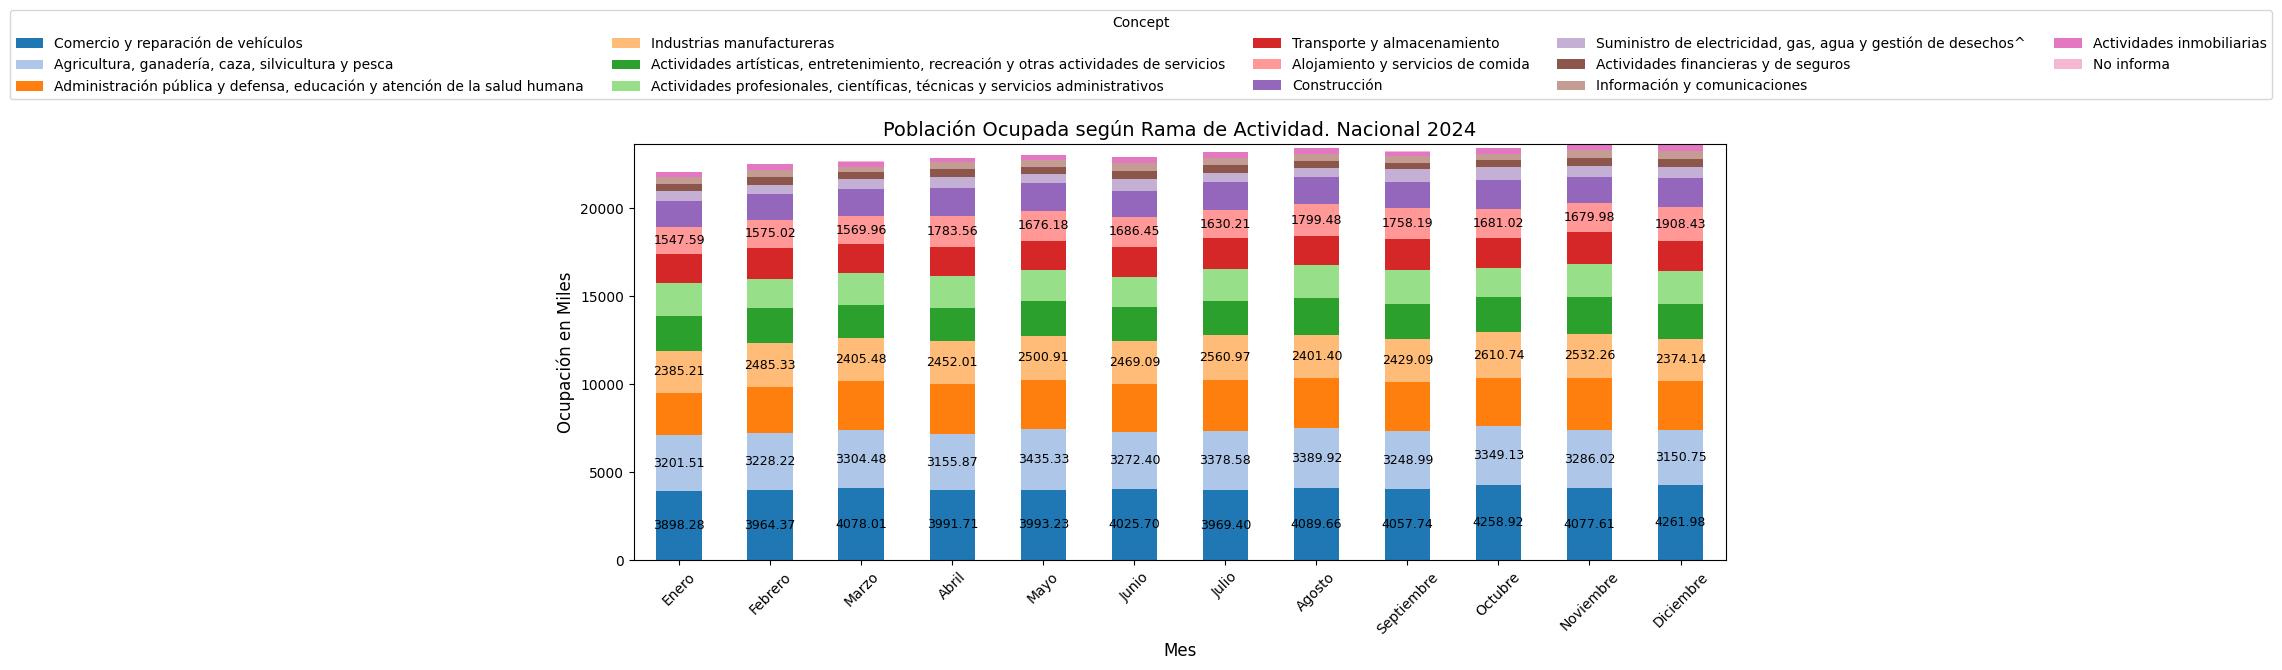

In [ ]:
# @title
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Diccionario para mapear números de mes a nombres en español
meses_espanol = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio",
    7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

vibrant_colors = list(plt.cm.tab20.colors)
vibrant_colors = vibrant_colors[:len(sorted_concepts_2024)]  # Validamos número de conceptos

# Mapeamos colores para cada concepto
color_mapping_2024 = {concept: vibrant_colors[i % len(vibrant_colors)] for i, concept in enumerate(sorted_concepts_2024)}

# Creamos Plot para Valores Absolutos
fig1, ax1 = plt.subplots(figsize=(12, 6))

bars = pivot_data_2024.drop(columns='Total').plot(
    kind='bar',
    stacked=True,
    ax=ax1,
    color=[color_mapping_2024[concept] for concept in sorted_concepts_2024]
)

ax1.set_title('Población Ocupada según Rama de Actividad. Nacional 2024', fontsize=14)
ax1.set_ylabel('Ocupación en Miles', fontsize=12)
ax1.set_xlabel('Mes', fontsize=12)
ax1.set_xticks(range(len(pivot_data_2024.index)))
ax1.set_xticklabels([meses_espanol[int(mes)] for mes in pivot_data_2024.index], rotation=45)

# Etiquetas para "Industrias manufactureras"
if "Industrias manufactureras" in pivot_data_2024.columns:
    for rect, value in zip(
        bars.containers[sorted_concepts_2024.index("Industrias manufactureras")],
        pivot_data_2024["Industrias manufactureras"]
    ):
        if value > 0:
            ax1.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f'{value:.2f}',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Etiquetas para "Agricultura, ganadería, caza, silvicultura y pesca"
if "Agricultura, ganadería, caza, silvicultura y pesca" in pivot_data_2024.columns:
    for rect, value in zip(
        bars.containers[sorted_concepts_2024.index("Agricultura, ganadería, caza, silvicultura y pesca")],
        pivot_data_2024["Agricultura, ganadería, caza, silvicultura y pesca"]
    ):
        if value > 0:
            ax1.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f'{value:.2f}',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Etiquetas para "Alojamiento y servicios de comida"
if "Alojamiento y servicios de comida" in pivot_data_2024.columns:
    for rect, value in zip(
        bars.containers[sorted_concepts_2024.index("Alojamiento y servicios de comida")],
        pivot_data_2024["Alojamiento y servicios de comida"]
    ):
        if value > 0:
            ax1.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f'{value:.2f}',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Etiquetas para "Comercio y reparación de vehículos"
if "Comercio y reparación de vehículos" in pivot_data_2024.columns:
    for rect, value in zip(
        bars.containers[sorted_concepts_2024.index("Comercio y reparación de vehículos")],
        pivot_data_2024["Comercio y reparación de vehículos"]
    ):
        if value > 0:
            ax1.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f'{value:.2f}',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Incluimos Leyenda
handles, labels = ax1.get_legend_handles_labels()
legend_columns = min(5, len(labels))
fig1.legend(
    handles,
    labels,
    title='Concept',
    bbox_to_anchor=(0.5, 1.12),
    loc='upper center',
    ncol=legend_columns
)

ax1.get_legend().remove()

# Ajustamos layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#Población Ocupada por Rama de Actividad -ultimo Mes

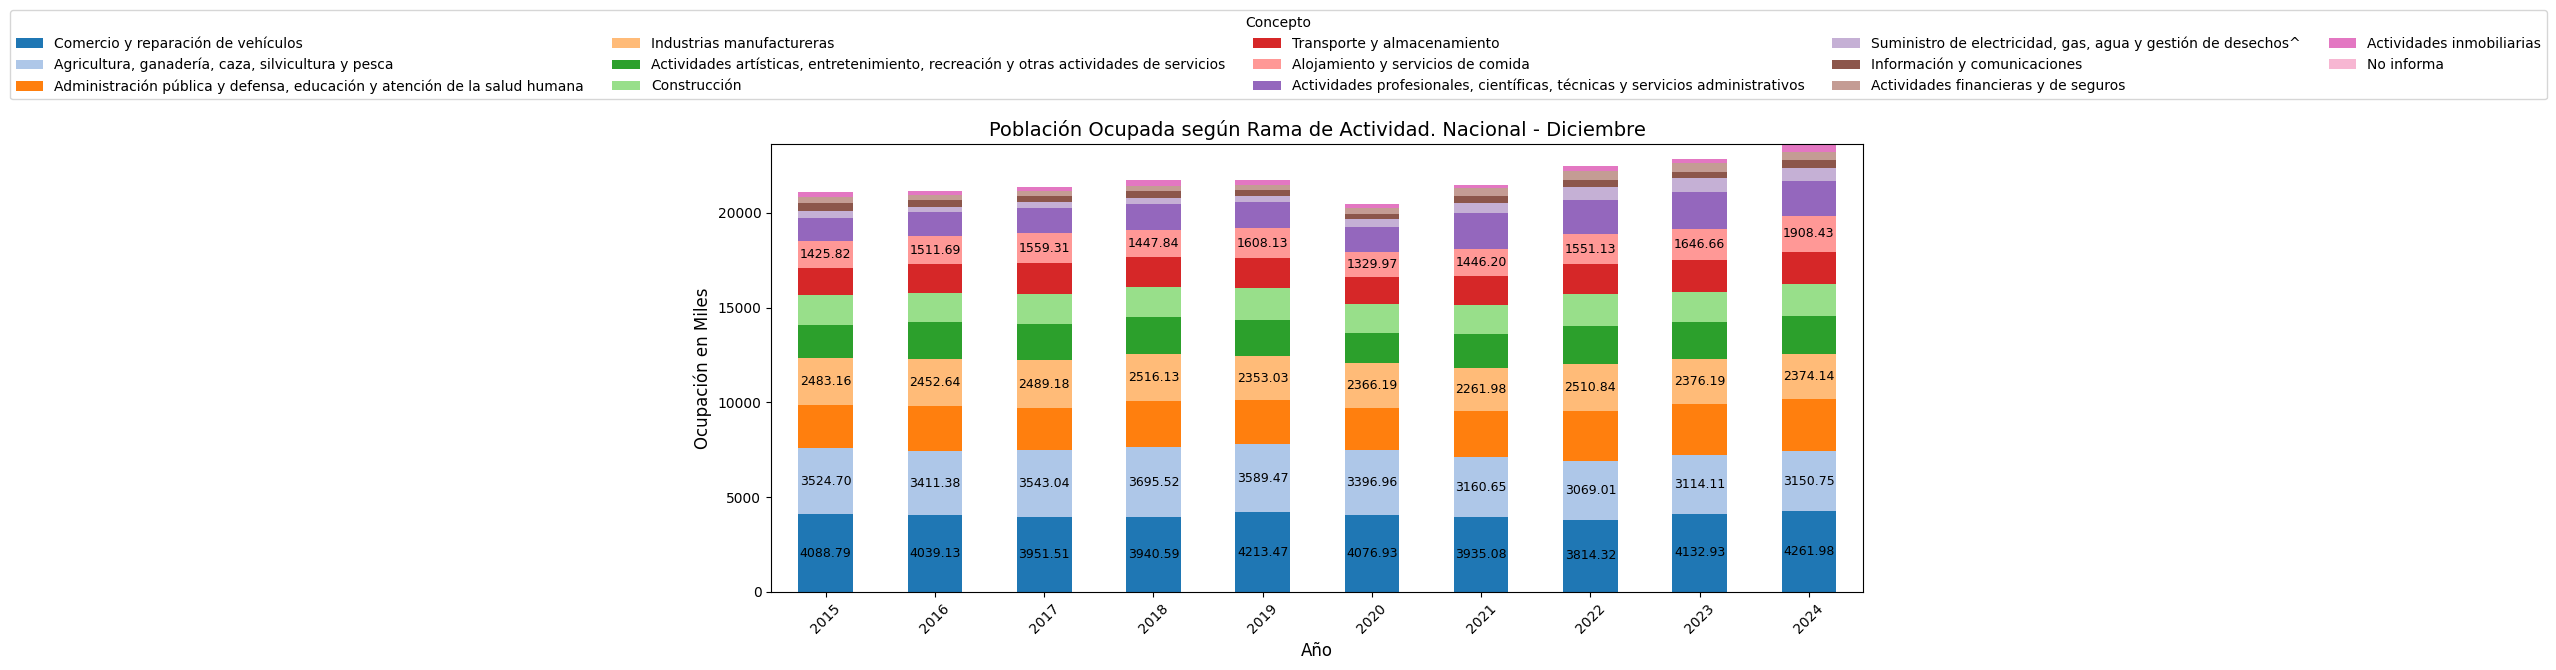

In [ ]:
# @title

# Diccionario para mapear números de mes a nombres en español
meses_espanol = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio",
    7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

# Generamos Tabla Dinámica y Organizamos por Suma
tidy_data_2024 = tidy_data[tidy_data['Year'] == 2024]

pivot_data_2024 = tidy_data_2024.pivot_table(
    index='Month',  # Agrupar solo por mes ya que estamos trabajando con un solo año
    columns='Concept',
    values='Value',
    aggfunc='sum'
).fillna(0)

pivot_data_2024['Total'] = pivot_data_2024.sum(axis=1)

sorted_concepts_2024 = pivot_data_2024.drop(columns=['Total']).sum().sort_values(ascending=False).index.tolist()

pivot_data_2024 = pivot_data_2024[sorted_concepts_2024 + ['Total']]  # Mantener "Total" al final

# Identificar el último año disponible
todos_los_anios = sorted(tidy_data['Year'].unique())
ulitmo_anio = todos_los_anios[-1]

# Identificar el último mes disponible para el último año
ultimo_mes = tidy_data[tidy_data['Year'] == ulitmo_anio]['Month'].max()

# Filtrar datos solo para el último mes en los años 2014 hasta el último disponible
anios_interes = list(range(2014, ulitmo_anio + 1))
pivot_data_filtrado = tidy_data[tidy_data['Year'].isin(anios_interes) & (tidy_data['Month'] == ultimo_mes)]

pivot_data_filtrado = pivot_data_filtrado.pivot_table(
    index='Year',
    columns='Concept',
    values='Value',
    aggfunc='sum'
).fillna(0)

pivot_data_filtrado['Total'] = pivot_data_filtrado.sum(axis=1)

sorted_concepts = pivot_data_filtrado.drop(columns=['Total']).sum().sort_values(ascending=False).index.tolist()

pivot_data_filtrado = pivot_data_filtrado[sorted_concepts + ['Total']]

# Definir colores
vibrant_colors = list(plt.cm.tab20.colors)
vibrant_colors = vibrant_colors[:len(sorted_concepts)]
color_mapping = {concept: vibrant_colors[i % len(vibrant_colors)] for i, concept in enumerate(sorted_concepts)}

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))

bars = pivot_data_filtrado.drop(columns='Total').plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=[color_mapping[concept] for concept in sorted_concepts]
)

ax.set_title(f'Población Ocupada según Rama de Actividad. Nacional - {meses_espanol[int(ultimo_mes)]}', fontsize=14)
ax.set_ylabel('Ocupación en Miles', fontsize=12)
ax.set_xlabel('Año', fontsize=12)
ax.set_xticks(range(len(pivot_data_filtrado.index)))
ax.set_xticklabels(pivot_data_filtrado.index, rotation=45)

# Etiquetas en las barras para conceptos clave
conceptos_destacados = [
    "Industrias manufactureras",
    "Agricultura, ganadería, caza, silvicultura y pesca",
    "Alojamiento y servicios de comida",
    "Comercio y reparación de vehículos"
]

for concepto in conceptos_destacados:
    if concepto in pivot_data_filtrado.columns:
        for rect, value in zip(
            bars.containers[sorted_concepts.index(concepto)],
            pivot_data_filtrado[concepto]
        ):
            if value > 0:
                ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + rect.get_height() / 2,
                    f'{value:.2f}',
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='black'
                )

# Leyenda
handles, labels = ax.get_legend_handles_labels()
legend_columns = min(5, len(labels))
fig.legend(
    handles,
    labels,
    title='Concepto',
    bbox_to_anchor=(0.5, 1.12),
    loc='upper center',
    ncol=legend_columns
)

ax.get_legend().remove()

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Porcentaje (%) de Población Ocupada según Rama Nacional 2024

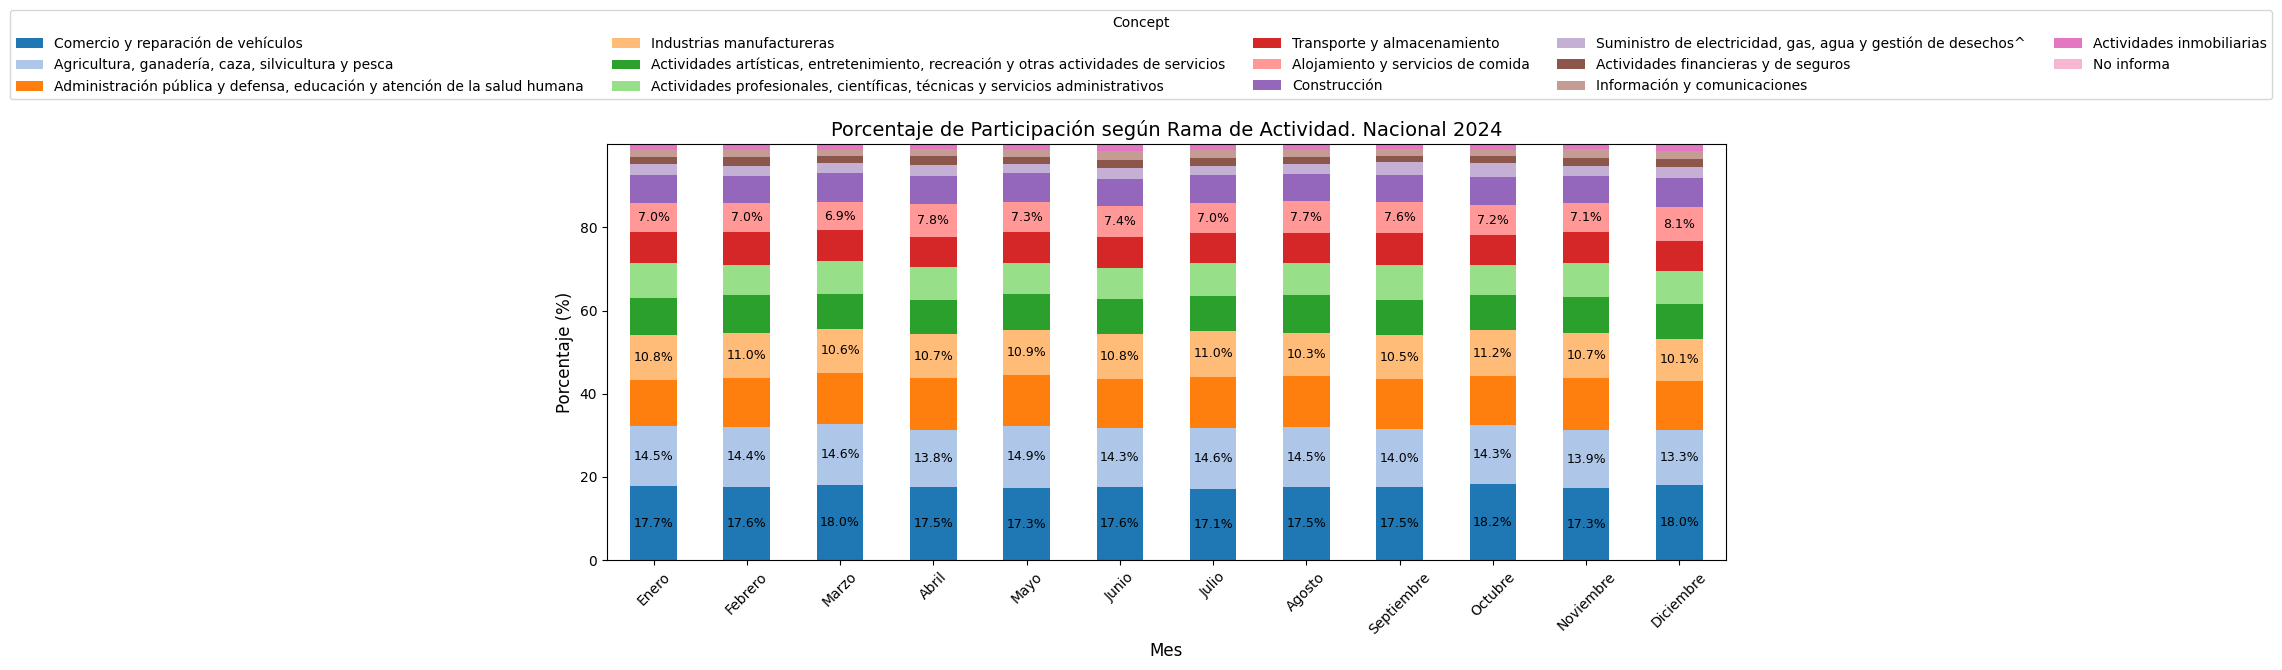

In [ ]:
# @title
import matplotlib.pyplot as plt

# Diccionario para mapear números de mes a nombres en español
meses_espanol = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio",
    7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

# Calculamos participación de cada concepto por mes
percentage_data_2024 = pivot_data_2024.div(pivot_data_2024['Total'], axis=0) * 100
percentage_data_2024 = percentage_data_2024.drop(columns='Total')

# Reordenamos
percentage_data_2024 = percentage_data_2024[sorted_concepts_2024]

# Plot
fig2, ax2 = plt.subplots(figsize=(12, 6))

percentage_bars = percentage_data_2024.plot(
    kind='bar',
    stacked=True,
    ax=ax2,
    color=[color_mapping_2024[concept] for concept in sorted_concepts_2024]
)

ax2.set_title('Porcentaje de Participación según Rama de Actividad. Nacional 2024', fontsize=14)
ax2.set_xlabel('Mes', fontsize=12)
ax2.set_ylabel('Porcentaje (%)', fontsize=12)
ax2.set_xticks(range(len(percentage_data_2024.index)))
ax2.set_xticklabels([meses_espanol[int(mes)] for mes in percentage_data_2024.index], rotation=45)

# Etiquetas 'Industrias manufactureras'
if "Industrias manufactureras" in percentage_data_2024.columns:
    for rect, value in zip(
        percentage_bars.containers[sorted_concepts_2024.index("Industrias manufactureras")],
        percentage_data_2024["Industrias manufactureras"]
    ):
        if value > 0:
            ax2.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f'{value:.1f}%',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Etiquetas 'Agricultura, ganadería, caza, silvicultura y pesca'
if "Agricultura, ganadería, caza, silvicultura y pesca" in percentage_data_2024.columns:
    for rect, value in zip(
        percentage_bars.containers[sorted_concepts_2024.index("Agricultura, ganadería, caza, silvicultura y pesca")],
        percentage_data_2024["Agricultura, ganadería, caza, silvicultura y pesca"]
    ):
        if value > 0:
            ax2.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f'{value:.1f}%',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Etiquetas "Alojamiento y servicios de comida"
if "Alojamiento y servicios de comida" in percentage_data_2024.columns:
    for rect, value in zip(
        percentage_bars.containers[sorted_concepts_2024.index("Alojamiento y servicios de comida")],
        percentage_data_2024["Alojamiento y servicios de comida"]
    ):
        if value > 0:
            ax2.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f'{value:.1f}%',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Etiquetas "Comercio y reparación de vehículos"
if "Comercio y reparación de vehículos" in percentage_data_2024.columns:
    for rect, value in zip(
        percentage_bars.containers[sorted_concepts_2024.index("Comercio y reparación de vehículos")],
        percentage_data_2024["Comercio y reparación de vehículos"]
    ):
        if value > 0:
            ax2.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f'{value:.1f}%',
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Adicionamos leyenda
handles, labels = ax2.get_legend_handles_labels()
legend_columns = min(5, len(labels))
fig2.legend(
    handles,
    labels,
    title='Concept',
    bbox_to_anchor=(0.5, 1.12),
    loc='upper center',
    ncol=legend_columns
)

ax2.get_legend().remove()

# Ajustamos layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Porcentaje (%) de Población Ocupada por Rama Último Mes

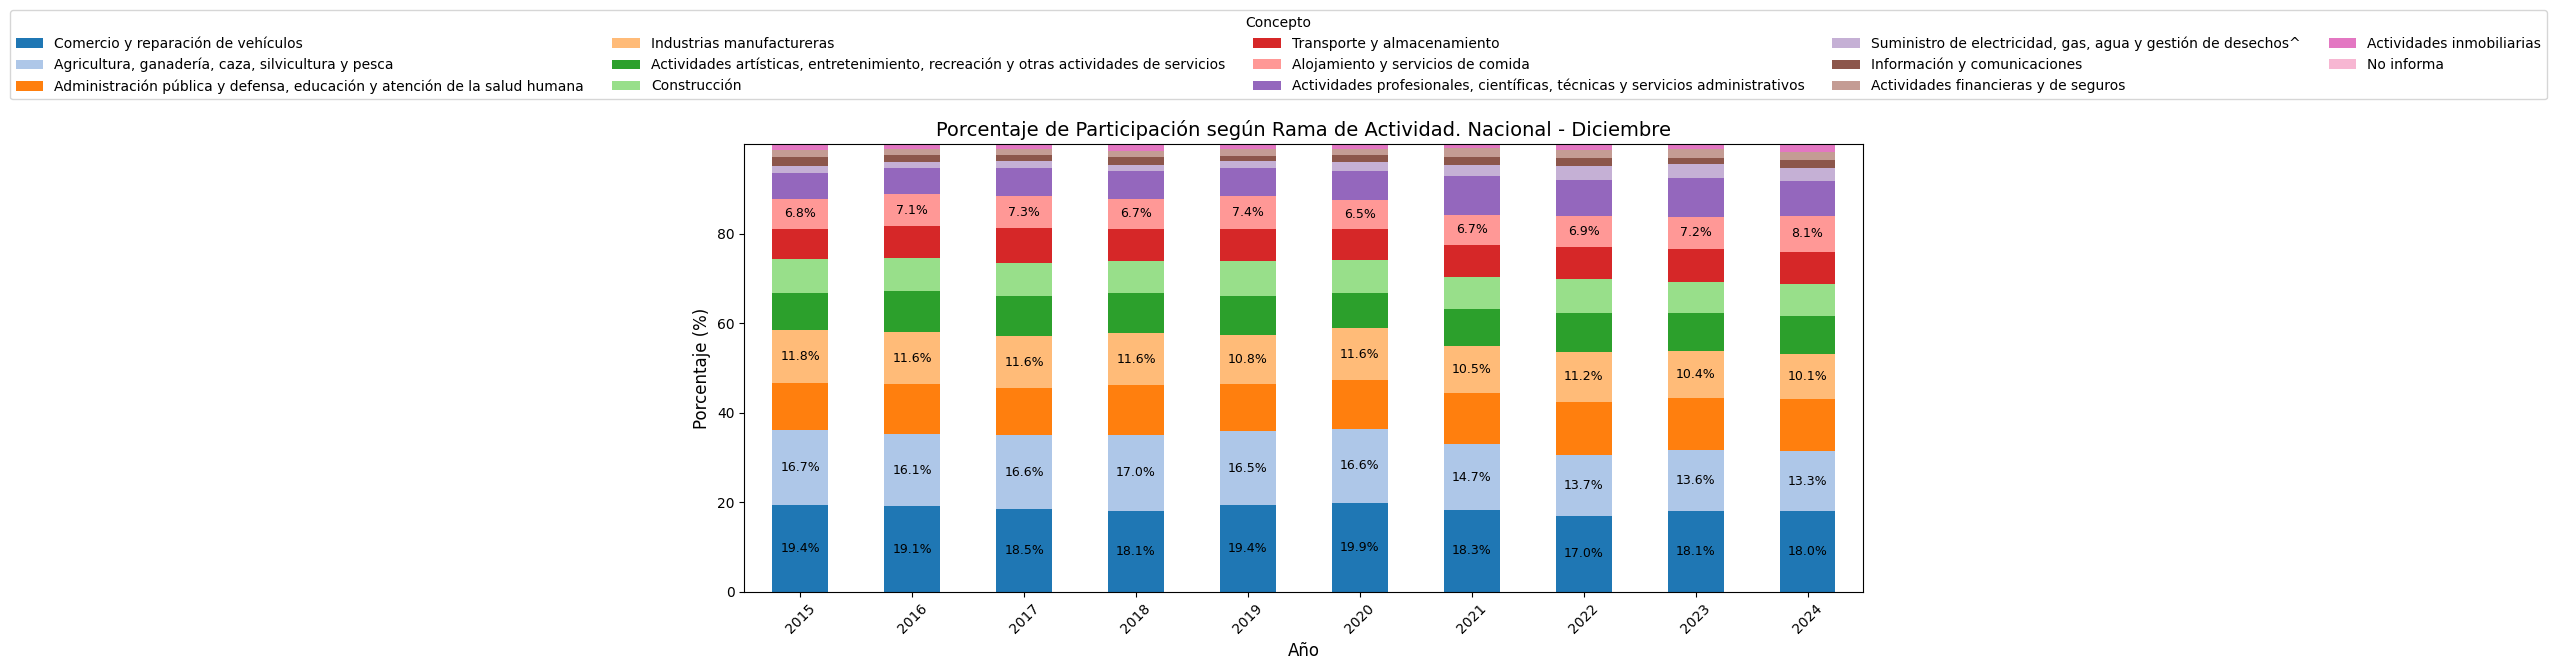

In [ ]:
# @title
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd

# Diccionario para mapear números de mes a nombres en español
meses_espanol = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio",
    7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

# Generamos Tabla Dinámica y Organizamos por Suma
tidy_data_2024 = tidy_data[tidy_data['Year'] == 2024]

pivot_data_2024 = tidy_data_2024.pivot_table(
    index='Month',
    columns='Concept',
    values='Value',
    aggfunc='sum'
).fillna(0)

pivot_data_2024['Total'] = pivot_data_2024.sum(axis=1)

sorted_concepts_2024 = pivot_data_2024.drop(columns=['Total']).sum().sort_values(ascending=False).index.tolist()

pivot_data_2024 = pivot_data_2024[sorted_concepts_2024 + ['Total']]

# Identificar el último año disponible
todos_los_anios = sorted(tidy_data['Year'].unique())
ulitmo_anio = todos_los_anios[-1]

# Identificar el último mes disponible para el último año
ultimo_mes = tidy_data[tidy_data['Year'] == ulitmo_anio]['Month'].max()

# Filtrar datos solo para el último mes en los años 2014 hasta el último disponible
anios_interes = list(range(2014, ulitmo_anio + 1))
pivot_data_filtrado = tidy_data[tidy_data['Year'].isin(anios_interes) & (tidy_data['Month'] == ultimo_mes)]

pivot_data_filtrado = pivot_data_filtrado.pivot_table(
    index='Year',
    columns='Concept',
    values='Value',
    aggfunc='sum'
).fillna(0)

pivot_data_filtrado['Total'] = pivot_data_filtrado.sum(axis=1)

percentage_data = pivot_data_filtrado.div(pivot_data_filtrado['Total'], axis=0) * 100
percentage_data = percentage_data.drop(columns='Total')

sorted_concepts = percentage_data.sum().sort_values(ascending=False).index.tolist()

percentage_data = percentage_data[sorted_concepts]

# Definir colores
vibrant_colors = list(plt.cm.tab20.colors)
vibrant_colors = vibrant_colors[:len(sorted_concepts)]
color_mapping = {concept: vibrant_colors[i % len(vibrant_colors)] for i, concept in enumerate(sorted_concepts)}

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))

bars = percentage_data.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=[color_mapping[concept] for concept in sorted_concepts]
)

ax.set_title(f'Porcentaje de Participación según Rama de Actividad. Nacional - {meses_espanol[int(ultimo_mes)]}', fontsize=14)
ax.set_ylabel('Porcentaje (%)', fontsize=12)
ax.set_xlabel('Año', fontsize=12)
ax.set_xticks(range(len(percentage_data.index)))
ax.set_xticklabels(percentage_data.index, rotation=45)

# Etiquetas en las barras para conceptos clave
conceptos_destacados = [
    "Industrias manufactureras",
    "Agricultura, ganadería, caza, silvicultura y pesca",
    "Alojamiento y servicios de comida",
    "Comercio y reparación de vehículos"
]

for concepto in conceptos_destacados:
    if concepto in percentage_data.columns:
        for rect, value in zip(
            bars.containers[sorted_concepts.index(concepto)],
            percentage_data[concepto]
        ):
            if value > 0:
                ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + rect.get_height() / 2,
                    f'{value:.1f}%',
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='black'
                )

# Leyenda
handles, labels = ax.get_legend_handles_labels()
legend_columns = min(5, len(labels))
fig.legend(
    handles,
    labels,
    title='Concepto',
    bbox_to_anchor=(0.5, 1.12),
    loc='upper center',
    ncol=legend_columns
)

ax.get_legend().remove()

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

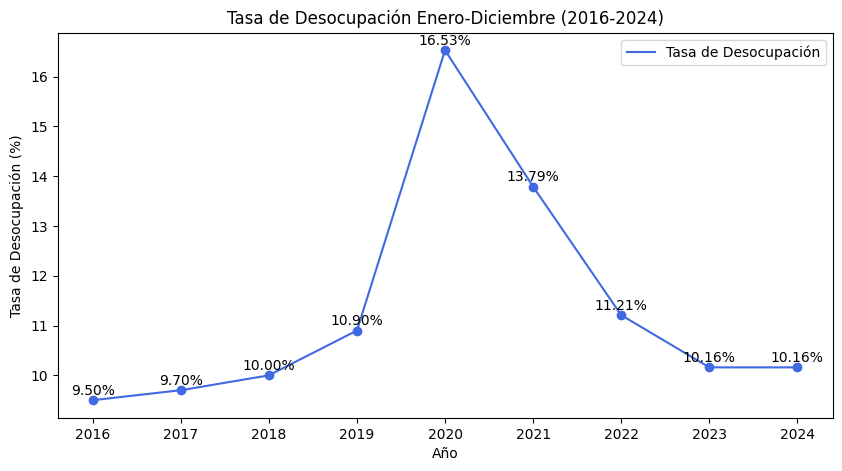

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Datos actualizados de tasa de desempleo (TD)
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
unemployment_rates = [9.50, 9.70, 10.00, 10.90, 16.53, 13.79, 11.21, 10.16, 10.16]  # Nuevos datos

# Suavizamos la línea
smooth_years = np.linspace(min(years), max(years), 300)
smooth_rates = np.interp(smooth_years, years, unemployment_rates)

# Creamos la gráfica
plt.figure(figsize=(10, 5))
plt.plot(smooth_years, smooth_rates, linestyle='-', color='royalblue', label="Tasa de Desocupación")
plt.scatter(years, unemployment_rates, color='royalblue')

# Etiquetas en los puntos
for year, rate in zip(years, unemployment_rates):
    plt.text(year, rate + 0.05, f"{rate:.2f}%", fontsize=10, verticalalignment='bottom', horizontalalignment='center')

# Etiquetas de los ejes
plt.xlabel("Año")
plt.ylabel("Tasa de Desocupación (%)")
plt.title("Tasa de Desocupación Enero-Diciembre (2016-2024)")
plt.legend()

# Configuración de los ticks del eje x
plt.xticks(years)

# Mostrar gráfica
plt.show()


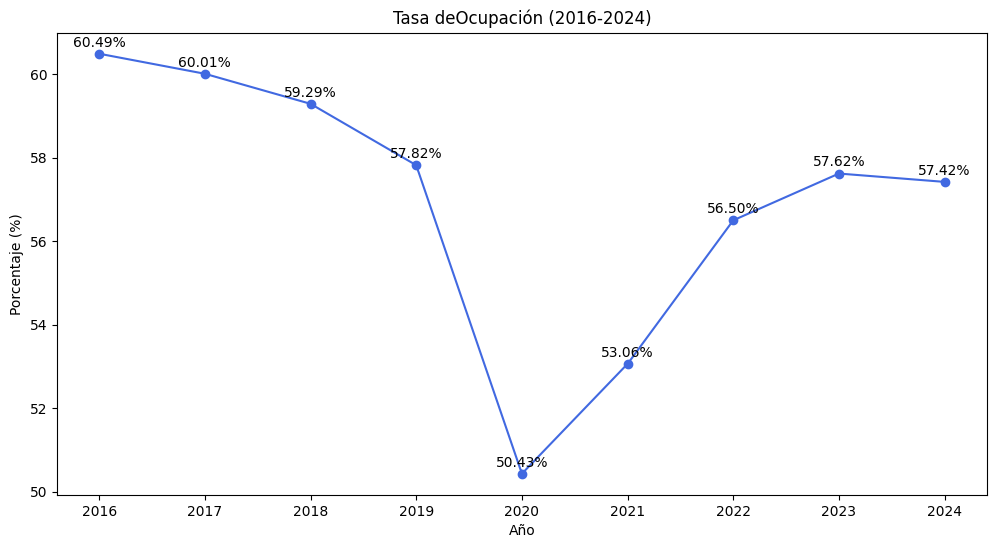

In [ ]:
# @title
# Datos de porcentaje
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
percentages = [60.49, 60.01, 59.29, 57.82, 50.43, 53.06, 56.50, 57.62, 57.42]

# Suavizamos la línea
smooth_years = np.linspace(min(years), max(years), 300)
smooth_percentages = np.interp(smooth_years, years, percentages)

# Creamos la gráfica
plt.figure(figsize=(12, 6))
plt.plot(smooth_years, smooth_percentages, linestyle='-', color='royalblue')
plt.scatter(years, percentages, color='royalblue')

# Etiquetas de los puntos
for year, percentage in zip(years, percentages):
    plt.text(year, percentage + 0.1, f"{percentage:.2f}%", fontsize=10, verticalalignment='bottom', horizontalalignment='center')

# Etiquetas de los ejes
plt.xlabel("Año")
plt.ylabel("Porcentaje (%)")
plt.title("Tasa deOcupación (2016-2024)")

# Configuración de los ticks del eje x
plt.xticks(np.arange(min(years), max(years) + 1, 1))

# Mostrar gráfica
plt.show()

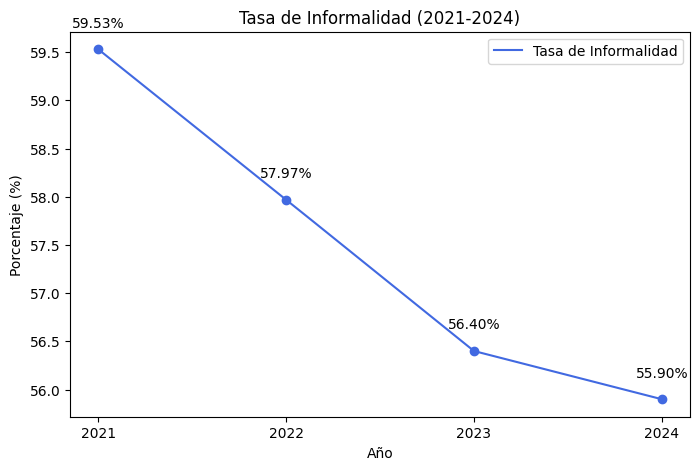

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Nuevos datos de porcentaje (solo 2021-2024)
years = [2021, 2022, 2023, 2024]
percentages = [59.53, 57.97, 56.40, 55.90]

# Suavizamos la línea
smooth_years = np.linspace(min(years), max(years), 300)
smooth_percentages = np.interp(smooth_years, years, percentages)

# Creamos la gráfica
plt.figure(figsize=(8, 5))
plt.plot(smooth_years, smooth_percentages, linestyle='-', color='royalblue', label="Tasa de Informalidad")
plt.scatter(years, percentages, color='royalblue')

# Etiquetas de los puntos
for year, percentage in zip(years, percentages):
    plt.text(year, percentage + 0.2, f"{percentage:.2f}%", fontsize=10, verticalalignment='bottom', horizontalalignment='center')

# Etiquetas de los ejes
plt.xlabel("Año")
plt.ylabel("Porcentaje (%)")
plt.title("Tasa de Informalidad (2021-2024)")
plt.legend()

# Configuración de los ticks del eje x
plt.xticks(years)

# Mostrar gráfica
plt.show()



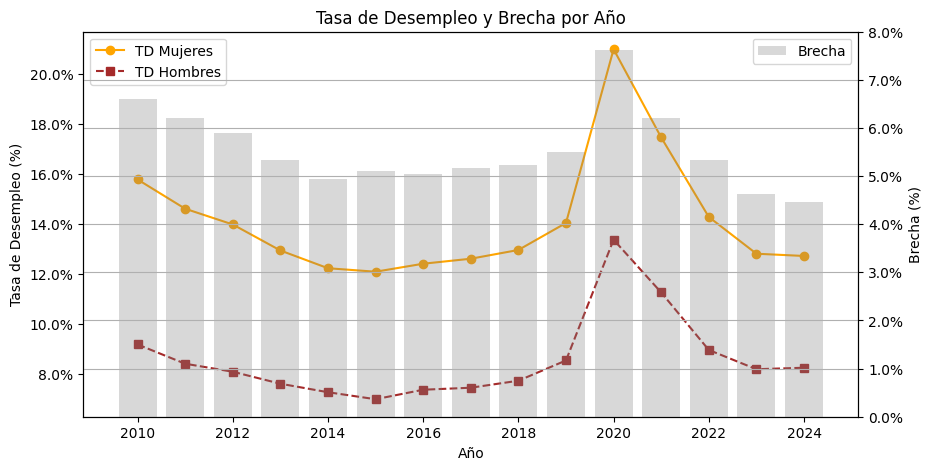

In [ ]:
# Brecha Tasa Desempleo Hombre-Mujeres

import pandas as pd
import matplotlib.pyplot as plt

# Data Frame
data = {
    "Año": list(range(2010, 2025)),
    "TD Mujeres": [15.78, 14.61, 13.98, 12.94, 12.23, 12.09, 12.41, 12.61, 12.96, 14.04, 20.99, 17.46, 14.28, 12.81, 12.72],
    "TD Hombres": [9.18, 8.41, 8.09, 7.61, 7.27, 6.99, 7.37, 7.45, 7.73, 8.54, 13.37, 11.26, 8.96, 8.19, 8.25],
    "Brecha": [6.60, 6.20, 5.89, 5.33, 4.95, 5.10, 5.04, 5.16, 5.23, 5.50, 7.62, 6.20, 5.33, 4.62, 4.47]
}

df = pd.DataFrame(data)

# Estructura Gráfico
fig, ax1 = plt.subplots(figsize=(10,5))

# Segundo Eje
ax2 = ax1.twinx()

# Líneas para TD
ax1.plot(df["Año"], df["TD Mujeres"], label="TD Mujeres", marker="o", linestyle="-", color="orange")
ax1.plot(df["Año"], df["TD Hombres"], label="TD Hombres", marker="s", linestyle="--", color="brown")

# Barras para Brecha
ax2.bar(df["Año"], df["Brecha"], alpha=0.3, color="gray", label="Brecha")

# Etiquetas y Título
ax1.set_xlabel("Año")
ax1.set_ylabel("Tasa de Desempleo (%)")
ax2.set_ylabel("Brecha (%)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# FormattingEtiquetas
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}%"))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}%"))

# Gráfico
plt.title("Tasa de Desempleo y Brecha por Año")
plt.grid()
plt.show()
